In [1]:
import numpy as np  
import matplotlib.pyplot as plt 
import os                  
from PIL import Image
import pandas as pd 

import tensorflow as tf
import keras 
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Activation, Dropout, BatchNormalization  
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import Model, layers
from tensorflow.keras.models import load_model

from aipilot.tf.cv import DataPrep , GradCam
from aipilot.tf import Devices, callbacks, Evaluator

In [2]:
# Check if TensorFlow can detect a GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
devices = Devices()
devices.gpu_device

[INFO] Tensorflow is built with cuda support ✅
[INFO] [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[INFO] {'device_name': 'NVIDIA GeForce RTX 3060 Laptop GPU', 'compute_capability': (8, 6)}


In [4]:
# Set the base directory to the dataset's root
BASE_DIR = "C:\\brain-tumor-classification-notebooks"

# Define the dataset directory
DATA_DIR = os.path.join(BASE_DIR, "cropped", "Training")

# Define the artifacts directory
ARTIFACTS_DIR = os.path.join(BASE_DIR, "artifacts")
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

# Define the checkpoint directory
CKPT_DIR = os.path.join(ARTIFACTS_DIR, "ckpt")
os.makedirs(CKPT_DIR, exist_ok=True)

# Define the models directory
MODELS_DIR = os.path.join(ARTIFACTS_DIR, "models")
os.makedirs(MODELS_DIR, exist_ok=True)

# Define the logs directory
LOGS_DIR = os.path.join(BASE_DIR, "logs")
os.makedirs(LOGS_DIR, exist_ok=True)

# Define file names for the checkpoint and model
CKPT_FILE_NAME = os.path.join(CKPT_DIR, ".mdl_wts.hdf5")
MODEL_NAME = os.path.join(MODELS_DIR, "model.h5")

# Print paths to verify
print("Dataset Directory:", DATA_DIR)
print("Artifacts Directory:", ARTIFACTS_DIR)
print("Checkpoint File Path:", CKPT_FILE_NAME)
print("Model File Path:", MODEL_NAME)
print("Logs Directory:", LOGS_DIR)

Dataset Directory: C:\brain-tumor-classification-notebooks\cropped\Training
Artifacts Directory: C:\brain-tumor-classification-notebooks\artifacts
Checkpoint File Path: C:\brain-tumor-classification-notebooks\artifacts\ckpt\.mdl_wts.hdf5
Model File Path: C:\brain-tumor-classification-notebooks\artifacts\models\model.h5
Logs Directory: C:\brain-tumor-classification-notebooks\logs


Found 5712 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


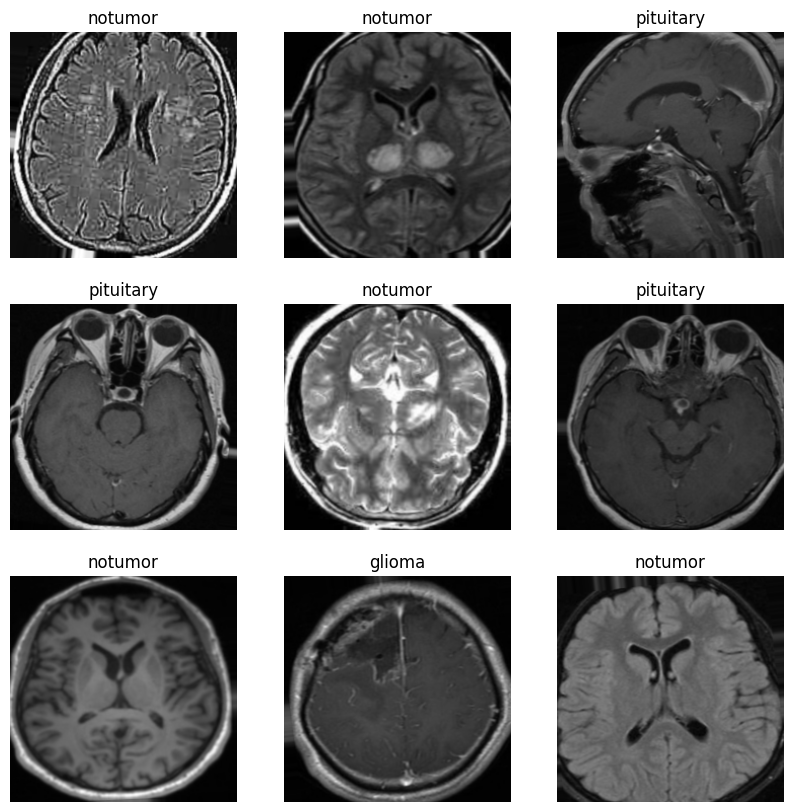

In [5]:
data_ops = DataPrep(DATA_DIR)
custom_data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=10,                        
        width_shift_range=0.05,
        rescale=1./255,
        height_shift_range=0.05,
        horizontal_flip=True)
train_generator, valid_generator = data_ops.data_generators( val_split=0.2, batch_size=16,
                                                            data_augmentation= True,
                                                            augmentation_strategy= custom_data_augmentation)
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
img = data_ops.sample_images(train_generator)

In [6]:
data_ops.classwise_img_count(train_generator)

{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}

In [7]:
data_ops.classwise_img_count(valid_generator)

{'glioma': 264, 'meningioma': 267, 'notumor': 319, 'pituitary': 291}

In [8]:
(early_stopping_cb, checkpointing_cb,
 tensorboard_cb, reduce_on_plateau_cb) = callbacks(
                                                   CKPT_FILE_NAME,LOGS_DIR, es_patience=10, lr_patience=3
                                                    )

In [38]:
conv_base = EfficientNetB3(
        include_top=False,
        weights='imagenet',
        input_shape = (300, 300, 3)
)
for layer in conv_base.layers[:-5]:
    layer.trainable = False

In [53]:
x = conv_base.output    
x = GlobalAveragePooling2D()(x)
x = Dense(units=512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(units=128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(units=64)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dense(units=32, activation='relu')(x)
predictions = layers.Dense(4, activation='softmax')(x)
model = Model(conv_base.input, outputs = predictions)

In [54]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [55]:
history = []

In [56]:
h = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=50,
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps,
    callbacks = [tensorboard_cb , early_stopping_cb, checkpointing_cb, reduce_on_plateau_cb]
    )
history.append(h)

Epoch 1/50
357/357 [==============================] - 57s 144ms/step - loss: 0.5003 - accuracy: 0.8130 - val_loss: 0.3367 - val_accuracy: 0.8688 - lr: 0.0010
Epoch 2/50
357/357 [==============================] - 52s 146ms/step - loss: 0.3209 - accuracy: 0.8813 - val_loss: 0.2007 - val_accuracy: 0.9269 - lr: 0.0010
Epoch 3/50
357/357 [==============================] - 55s 154ms/step - loss: 0.2875 - accuracy: 0.8902 - val_loss: 0.1709 - val_accuracy: 0.9349 - lr: 0.0010
Epoch 4/50
357/357 [==============================] - 55s 154ms/step - loss: 0.2462 - accuracy: 0.9077 - val_loss: 0.1522 - val_accuracy: 0.9445 - lr: 0.0010
Epoch 5/50
357/357 [==============================] - 54s 150ms/step - loss: 0.2441 - accuracy: 0.9128 - val_loss: 0.1626 - val_accuracy: 0.9366 - lr: 0.0010
Epoch 6/50
357/357 [==============================] - 55s 153ms/step - loss: 0.1977 - accuracy: 0.9279 - val_loss: 0.1257 - val_accuracy: 0.9463 - lr: 0.0010
Epoch 7/50
357/357 [==============================] 

Epoch 49/50
357/357 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.9891
Epoch 49: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
357/357 [==============================] - 58s 161ms/step - loss: 0.0356 - accuracy: 0.9891 - val_loss: 0.0043 - val_accuracy: 0.9991 - lr: 8.0000e-06
Epoch 50/50
357/357 [==============================] - 58s 163ms/step - loss: 0.0367 - accuracy: 0.9872 - val_loss: 0.0045 - val_accuracy: 0.9991 - lr: 1.6000e-06


In [65]:
saved_ckpt = os.path.join( CKPT_FILE_NAME)
loaded_ckpt = keras.models.load_model(saved_ckpt)

In [71]:
#starting the training again from the last checkpoint
h = loaded_ckpt.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=50,
    steps_per_epoch=steps_per_epoch, 
    validation_steps=validation_steps,
    callbacks = [tensorboard_cb , early_stopping_cb, checkpointing_cb, reduce_on_plateau_cb]
    )
history.append(h)

In [66]:
history_df = pd.DataFrame()
for h in history:
    history_df = pd.concat([history_df, pd.DataFrame.from_records(h.history)])

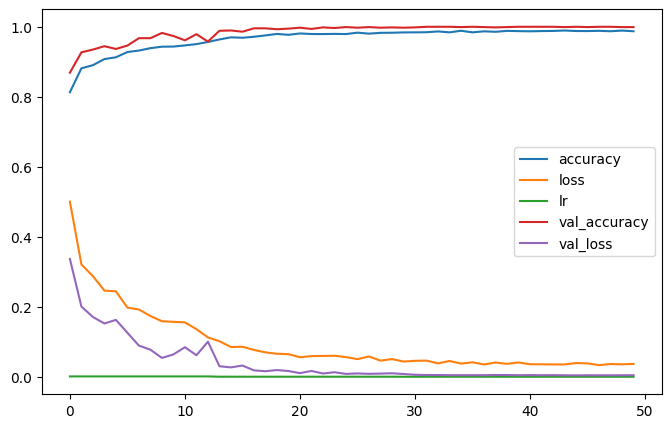

In [67]:
history_df.reset_index(drop=True).plot(figsize= (8,5));

## Saving and Loading Model

In [72]:
model = load_model(CKPT_FILE_NAME)
model.save(MODEL_NAME)

In [73]:
model = load_model(MODEL_NAME)